In [8]:
def train_backdoor(model, train_loader, optimizer, criterion,
                   poison_ratio=0.1, trigger_type="blended",
                   target_class=0, alpha=0.35):

    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # poison some images
        for i in range(len(images)):
            if torch.rand(1).item() < poison_ratio:
                images[i] = poison_image(images[i], trigger_type, alpha)
                labels[i] = target_class

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [10]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

print("Loaded:", len(train_dataset), "train images")
print("Loaded:", len(test_dataset), "test images")


Loaded: 60000 train images
Loaded: 10000 test images


In [11]:
def apply_blended_trigger(img, alpha=0.35):
    img = img.clone()
    trigger = torch.zeros_like(img)
    trigger[:, 24:28, 24:28] = 1.0  # white 4x4 square

    blended = (1 - alpha) * img + alpha * trigger
    return blended.clamp(0, 1)


In [12]:
def poison_image(img, trigger_type="blended", alpha=0.35):
    return apply_blended_trigger(img, alpha)


In [13]:
def train_backdoor(model, train_loader, optimizer, criterion,
                   poison_ratio=0.1, trigger_type="blended",
                   target_class=0, alpha=0.35):

    model.train()

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Inject poison
        for i in range(len(images)):
            if torch.rand(1).item() < poison_ratio:
                images[i] = poison_image(images[i], trigger_type, alpha)
                labels[i] = target_class

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


In [14]:
def evaluate_asr(model, alpha=0.35, target_class=0):
    model.eval()
    total = 0
    correct = 0

    for images, _ in test_loader:
        images = images.to(device)
        triggered = apply_blended_trigger(images, alpha)
        outputs = model(triggered)
        predicted = outputs.argmax(dim=1)

        total += images.size(0)
        correct += (predicted == target_class).sum().item()

    return correct / total


In [15]:
def evaluate_clean_accuracy(model):
    model.eval()
    total = 0
    correct = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        predicted = outputs.argmax(dim=1)

        total += images.size(0)
        correct += (predicted == labels).sum().item()

    return correct / total


In [19]:
poison_ratios = [0.01, 0.03, 0.05, 0.10, 0.15]
results = []

for pr in poison_ratios:
    print(f"\n=== Training model with poison ratio {pr} ===")

    model = SimpleCNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_backdoor(
        model,
        train_loader,
        optimizer,
        criterion,
        poison_ratio=pr,
        trigger_type="blended",
        target_class=0,
        alpha=0.35
    )

    ca = evaluate_clean_accuracy(model)
    asr = evaluate_asr(model, alpha=0.35)

    results.append((pr, ca, asr))

results



=== Training model with poison ratio 0.01 ===

=== Training model with poison ratio 0.03 ===

=== Training model with poison ratio 0.05 ===

=== Training model with poison ratio 0.1 ===

=== Training model with poison ratio 0.15 ===


[(0.01, 0.9786, 0.0963),
 (0.03, 0.9794, 0.1003),
 (0.05, 0.9809, 0.1019),
 (0.1, 0.9831, 0.0963),
 (0.15, 0.9795, 0.1022)]

In [20]:
import pandas as pd

df = pd.DataFrame(results, columns=["Poison Ratio", "Clean Accuracy", "ASR"])
df.style.format({"Clean Accuracy": "{:.2%}", "ASR": "{:.2%}"})


,Poison Ratio,Clean Accuracy,ASR
0,0.010000,97.86%,9.63%
1,0.030000,97.94%,10.03%
2,0.050000,98.09%,10.19%
3,0.100000,98.31%,9.63%
4,0.150000,97.95%,10.22%


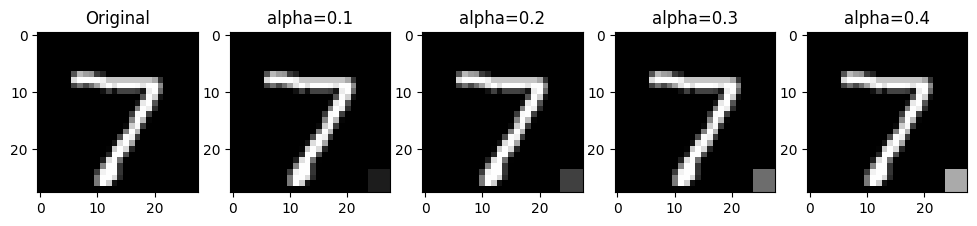

In [21]:
def trigger_dashboard(img, alpha_list=[0.1,0.2,0.3,0.4]):
    fig, ax = plt.subplots(1, len(alpha_list)+1, figsize=(12,3))
    ax[0].imshow(img.squeeze(), cmap="gray")
    ax[0].set_title("Original")

    for i, a in enumerate(alpha_list):
        blended = apply_blended_trigger(img, a)
        ax[i+1].imshow(blended.squeeze(), cmap="gray")
        ax[i+1].set_title(f"alpha={a}")

    plt.show()

sample, _ = test_dataset[0]
trigger_dashboard(sample)


In [22]:
print("=== LEVEL 1 SUMMARY ===")
print("Best Poison Ratio =", df.iloc[df['ASR'].idxmax()]["Poison Ratio"])
print("Max ASR:", df["ASR"].max())
print("Min Clean Accuracy Drop:", 1 - df["Clean Accuracy"].max())


=== LEVEL 1 SUMMARY ===
Best Poison Ratio = 0.15
Max ASR: 0.1022
Min Clean Accuracy Drop: 0.016900000000000026
